# V1 Legacy

Important Version Downfalls:
- Bias values are false and corrected later.
- RSME is included in here but was never used in the final version and analysis. We instead used RSMB.
- Uses tuples and other hard to follow techniques.

# IMPORTS

In [1]:
# Import necessary libraries
import os  # For interacting with the operating system
import numpy as np  # For numerical operations
import datetime  # For manipulating dates and times
import pandas as pd  # For data manipulation and analysis
import matplotlib as mpl  # For creating visualizations
import warnings  # For handling warnings
import matplotlib.pyplot as plt  # For creating plots
import xarray as xr  # For working with labeled multidimensional arrays
import matplotlib.colors as colors
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from tabulate import tabulate

import scipy.stats as stats  # For statistical operations
from sklearn.metrics import mean_squared_error  # For calculating mean squared error

# Set configuration for suppressing warnings and plots
suppress_warnings = True  # Set to True to suppress warnings
suppress_plots = False  # Set to True to suppress plots

# Suppress Warnings
if suppress_warnings:
    warnings.filterwarnings("ignore")  # Suppress all warnings

# Set backend for Matplotlib to non-interactive mode if suppress_plots is True
if suppress_plots:
    import matplotlib
    matplotlib.use("Agg")  # Use the 'Agg' backend for non-interactive image generation

# Print current date and versions of imported libraries
print(datetime.datetime.ctime(datetime.datetime.today()))  # Print the current date and time
print("Matplotlib: ", mpl.__version__)  # Print the version of Matplotlib
print("Numpy     : ", np.__version__)  # Print the version of NumPy
print("Pandas   : ", pd.__version__)  # Print the version of Pandas
print("Xarray   : ", xr.__version__)  # Print the version of Xarray

Mon Jan 29 11:35:33 2024
Matplotlib:  3.1.1
Numpy     :  1.17.2
Pandas   :  0.25.1
Xarray   :  0.14.0


# OPENING OCEAN TEMP PROXY DATA FILE

In [2]:
# Setting a path to the Excel file
path = '/glade/u/home/nwrye/OceanTemps_Compiles/PlioMIP2data.xlsx'

# Load data from Excel into a pandas DataFrame
df = pd.read_excel(path)

# Remove the third row (index 2)
df = df.drop(2, axis=0)

# Selecting specific columns from the DataFrame (longitude, depth, -95%CL, median, 95%CL)
data = df.iloc[:, [1, 2, 3, 4, 5, 6]]

# Convert DataFrame to a numpy array to allow direct indexing and modification
data_array = data.to_numpy()

# Find the indices of the negative values in the first column
negative_indices = data_array[:, 0] < 0

# Add 360 to the negative values using the indices
data_array[negative_indices, 0] += 360

# Convert the modified numpy array back to a DataFrame (if needed)
data_modified = pd.DataFrame(data_array, columns=data.columns)

# Renaming columns
data_modified.columns = ['longitude', 'depth', 'species', 'neg95', 'median', 'pos95']

# Changing the depth value in the first row to 10
data_modified.at[0:1, 'depth'] = 15

# Multiplying all values in the depth column by -1
data_modified['depth'] *= -1

# Replace NaN values in the 'longitude' column with 0 (or any default value)
data_modified['longitude'].fillna(0, inplace=True)

# Round the 'longitude' values to the nearest whole number
data_modified['longitude'] = data_modified['longitude'].round()

# Convert the DataFrame to an xarray Dataset
dsa = data_modified.to_xarray()

# Convert specific columns to desired data types
dsa['depth'] = dsa['depth'].astype('float')
dsa['neg95'] = dsa['neg95'].astype('float')
dsa['median'] = dsa['median'].astype('float')
dsa['pos95'] = dsa['pos95'].astype('float')
dsa['species'] = dsa['species'].astype('str')

# Print the resulting xarray Dataset
print(dsa)

<xarray.Dataset>
Dimensions:    (index: 7)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6
Data variables:
    longitude  (index) float64 265.0 159.0 159.0 278.0 159.0 249.0 278.0
    depth      (index) float64 -15.0 -15.0 -48.0 -114.0 -210.0 -210.0 -210.0
    species    (index) <U10 'alkenones' 'alkenones' ... 'tumida' 'tumida'
    neg95      (index) float64 1.338 0.8068 0.988 5.799 3.441 3.575 3.678
    median     (index) float64 2.434 1.168 0.923 6.593 3.8 4.05 4.298
    pos95      (index) float64 4.006 1.326 0.8945 7.791 4.658 4.726 5.489


# OPENING PLIOMIP2 ANNUAL MEAN OCEAN TEMP DATA FILES 

In [3]:
# Define the directory path for slice files
path = '/glade/u/home/nwrye/OceanTemps_Compiles/Equator Slice Files/'

# List of file names to process for plio files and pi files respectively
pliofile_names = ['CCSM4_plio.nc', 'CESM1.2_plio.nc', 'CESM2_plio.nc', 'COSMOS_plio.nc',
                'EC_Earth3.3_plio.nc', 'HADGEM3_NEW_1997_plio.nc','MIROC4_2004_plio.nc', 'Utrecht_CESM1.0.5_plio.nc','IPSLCM6A_LR_plio.nc', 'GISS_plio.nc',
                'LEEDS_plio.nc', 'NorESM-F_plio.nc','IPSLCM5A_plio.nc', 'IPSLCM5A2_plio.nc']

pifile_names = ['CCSM4_pi.nc', 'CESM1.2_pi.nc',
                'CESM2_pi.nc', 'COSMOS_pi.nc', 'EC_Earth3.3_pi.nc', 'HADGEM3_NEW_1997_pi.nc',
                'MIROC4_2004_pi.nc', 'Utrecht_CESM1.0.5_pi.nc','IPSLCM6A_LR_pi.nc', 'GISS_pi.nc','LEEDS_pi.nc', 'NorESM-F_pi.nc', 'IPSLCM5A_pi.nc', 'IPSLCM5A2_pi.nc' ]

# Create an empty list to store sliced datasets for plio and pi files
pisds = []
pliosds = []

# Open and interpolate plio files
# Iterate through each plio file
for fname in pliofile_names:
    try:
        # Open the NetCDF dataset
        with xr.open_dataset(os.path.join(path, fname)) as dataset:
            # Select data within the specified latitude and level range
            sliced = dataset.sel(lat=slice(-2, 2), lev=slice(None, 1500))
            
            pliosds.append(sliced)
            # Interpolate the data to the same level values as the first dataset if more than one dataset is present
            if len(pliosds) == 1:
                continue
            else:
                sliced_interp = sliced.interp(lev=pliosds[0].lev, method='linear')
                pliosds[-1] = sliced_interp
    except Exception as e:
        print(f"An error occurred while processing {fname}: {e}")

# Open and interpolate pi files
# Iterate through each pi file
for fname in pifile_names:
    try:
        # Open the NetCDF dataset
        with xr.open_dataset(os.path.join(path, fname)) as dataset:
            # Select data within the specified latitude and level range
            sliced = dataset.sel(lat=slice(-2, 2), lev=slice(None, 1500))
            pisds.append(sliced)
            # Interpolate the data to the same level values as the plio dataset if more than one dataset is present
            if len(pisds) == 1:
                continue
            else:
                sliced_interp = sliced.interp(lev=pliosds[0].lev, method='linear')
                pisds[-1] = sliced_interp
    except Exception as e:
        print(f"An error occurred while processing {fname}: {e}")

# Check if both groups of files are on the same lev grid after interpolation
if len(pliosds) > 0 and len(pisds) > 0:
    plio_lev_values = pliosds[0].lev.values
    pi_lev_values = pisds[0].lev.values

    # Check if the level values of plio and pi datasets are the same
    if (plio_lev_values == pi_lev_values).all():
        print("Both groups of files are on the same lev grid after interpolation.")
    else:
        print("Both groups of files are not on the same lev grid after interpolation.")
else:
    print("No data found to compare.")

Both groups of files are on the same lev grid after interpolation.


In [6]:
pliosds[0]

<xarray.Dataset>
Dimensions:  (lat: 5, lev: 43, lon: 360)
Coordinates:
    time     object ...
  * lev      (lev) float32 5.0 15.0 25.0 35.0 ... 1106.2042 1244.5669 1400.4972
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
  * lat      (lat) float64 -2.0 -1.0 0.0 1.0 2.0
Data variables:
    TEMP     (lev, lat, lon) float64 ...

# CREATING A MULTIMODEL MEAN FILE OF THE NEWLY INTERPOLATED SDS

In [4]:
# Take the mean across all datasets in the pliosds list
concatenated = xr.concat(pliosds, dim='concat_dim')  # Concatenate datasets along the specified dimension
mean_temp_across_datasets = concatenated['TEMP'].mean(dim='concat_dim')  # Calculate the mean of the 'TEMP' variable across the concatenated datasets

# Create a new xarray dataset
multiplio = xr.Dataset(
    {
        "TEMP": mean_temp_across_datasets  # Add the mean temperature data to the new dataset
    }
)

# Save the dataset to a NetCDF file
output_file_path = "/glade/u/home/nwrye/OceanTemps_Compiles/Equator Slice Files/multimodelmean_plio.nc"  # Specify the output file path
multiplio.to_netcdf(output_file_path)  # Save the dataset to the specified file path

# Confirm the file has been saved
print(f"NetCDF file saved at {output_file_path}")  # Print a confirmation message with the output file path

# Take the mean across all datasets in the pisds list
concatenated = xr.concat(pisds, dim='concat_dim')  # Concatenate datasets along the specified dimension
mean_temp_across_datasets = concatenated['TEMP'].mean(dim='concat_dim')  # Calculate the mean of the 'TEMP' variable across the concatenated datasets

# Create a new xarray dataset
multipi = xr.Dataset(
    {
        "TEMP": mean_temp_across_datasets  # Add the mean temperature data to the new dataset
    }
)

# Save the dataset to a NetCDF file
output_file_path = "/glade/u/home/nwrye/OceanTemps_Compiles/Equator Slice Files/multimodelmean_pi.nc"  # Specify the output file path
multipi.to_netcdf(output_file_path)  # Save the dataset to the specified file path

# Confirm the file has been saved
print(f"NetCDF file saved at {output_file_path}")  # Print a confirmation message with the output file path

NetCDF file saved at /glade/u/home/nwrye/OceanTemps_Compiles/Equator Slice Files/multimodelmean_plio.nc
NetCDF file saved at /glade/u/home/nwrye/OceanTemps_Compiles/Equator Slice Files/multimodelmean_pi.nc


# GRABING SPECIES DEPTH HABITAT DATA

In [5]:
# Set the path to the Excel file
excel_path = os.path.join('/glade/u/home/nwrye/OceanTemps_Compiles', 'Lakhani_depths.xlsx')

# Load data from the Excel file into a pandas DataFrame
df = pd.read_excel(excel_path)

# Filter the DataFrame to include only 'sacculifer', 'dutertrei', and 'tumida' species
selected_species = ['sacculifer', 'dutertrei', 'tumida']
df_filtered = df[df['species'].isin(selected_species)]

# Create an xarray dataset from the filtered DataFrame
ds = xr.Dataset.from_dataframe(df_filtered)

# Convert the 'species' column to string type
ds['species'] = ds['species'].astype(str)
ds

<xarray.Dataset>
Dimensions:     (index: 1129)
Coordinates:
  * index       (index) int64 729 730 731 732 733 ... 1853 1854 1855 1856 1857
Data variables:
    species     (index) <U10 'sacculifer' 'sacculifer' ... 'dutertrei'
    lat         (index) float64 -1.42 -12.48 -14.05 20.12 ... 2.46 2.77 2.97
    long        (index) float64 -86.85 146.9 147.9 ... -159.4 -159.3 -159.2
    d18O        (index) float64 -1.255 -1.75 -1.76 -1.915 ... -0.72 -0.92 -0.82
    calc_depth  (index) float64 15.17 69.6 71.44 33.54 ... 145.9 142.0 146.5

# HORIZONTAL DIFFERENCE FUNCTION

In [7]:
## Calculates the temp difference between the plio and pi datasets

# Define the function to calculate horizontal temperature difference
def horizontal_difference(plio_ds, pi_ds): 
    
    # Calculate the temperature difference between Pliocene and Preindustrial datasets along the latitude axis
    dif = plio_ds['TEMP'] - pi_ds['TEMP'] 
    diff = dif.mean('lat', skipna=True)
    return diff

### Assigning RGBA Values for pos95, neg95, and median for plotting

<xarray.DataArray 'neg95' (index: 7)>
array([0.63378038, 0.58067755, 0.59880417, 1.07992577, 0.8440589 ,
       0.85751527, 0.86777151])
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6
[(0.9473454036000001, 0.7946955047999998, 0.7169905057999999, 1.0), (0.705673158, 0.01555616, 0.150232812, 1.0), (0.8930743058, 0.427310192, 0.3346371132, 1.0), (0.8415338034000001, 0.3259621752, 0.2674943956, 1.0), (0.8415338034000001, 0.3259621752, 0.2674943956, 1.0)]


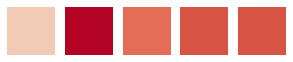

[(0.9473454036000001, 0.7946955047999998, 0.7169905057999999, 1.0), (0.705673158, 0.01555616, 0.150232812, 1.0), (0.8415338034000001, 0.3259621752, 0.2674943956, 1.0), (0.7783930206, 0.2076687008, 0.2059614254, 1.0), (0.7783930206, 0.2076687008, 0.2059614254, 1.0)]


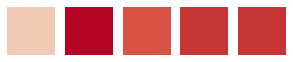

[(0.9473454036000001, 0.7946955047999998, 0.7169905057999999, 1.0), (0.705673158, 0.01555616, 0.150232812, 1.0), (0.705673158, 0.01555616, 0.150232812, 1.0), (0.705673158, 0.01555616, 0.150232812, 1.0), (0.705673158, 0.01555616, 0.150232812, 1.0)]


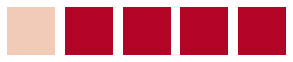

In [8]:
# Initialize an empty list to store RGBA values
neg95rgba_values = []

# Normalize the range between -5 and 5 degrees
normalized_values = (dsa['neg95'] - (-5)) / (5 - (-5))
print(normalized_values)

# Get the 'coolwarm' colormap
cmap = plt.get_cmap('coolwarm', 21)

# Iterate through the normalized values
for i in normalized_values:
    # Map the normalized value to a color using the colormap
    rgba = cmap(i)
    
    # Append the RGBA values to the list
    neg95rgba_values.append(rgba)
    
# Redefine the variable to drop the first two values
neg95rgba_values = neg95rgba_values[2:] 
print(neg95rgba_values)

# Create a 1xN grid of color boxes, where N is the length of medrgba_values
fig, axes = plt.subplots(1, len(neg95rgba_values), figsize=(len(neg95rgba_values), 2))

for i, rgba in enumerate(neg95rgba_values):
    ax = axes[i]

    # Create a rectangle filled with the specified color
    rectangle = plt.Rectangle((0, 0), 1, 1, fc=rgba)

    # Add the rectangle to the axis
    ax.add_patch(rectangle)

    # Set the aspect ratio to 'equal' so the rectangle appears as a square
    ax.set_aspect('equal')

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Remove axis labels and ticks
    ax.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the grid of color swatches
plt.show()

# Initialize an empty list to store RGBA values
medrgba_values = []

# Normalize the range between -5 and 5 degrees
normalized_values = (dsa['median'] - (-5)) / (5 - (-5))

# Get the 'coolwarm' colormap
cmap = plt.get_cmap('coolwarm', 21)

# Iterate through the normalized values
for i in normalized_values:
    # Map the normalized value to a color using the colormap
    rgba = cmap(i)
    
    # Append the RGBA values to the list
    medrgba_values.append(rgba)

# Redefine the variable to drop the first two values
medrgba_values = medrgba_values[2:]
print(medrgba_values)

# Create a 1xN grid of color boxes, where N is the length of medrgba_values
fig, axes = plt.subplots(1, len(medrgba_values), figsize=(len(medrgba_values), 2))

for i, rgba in enumerate(medrgba_values):
    ax = axes[i]

    # Create a rectangle filled with the specified color
    rectangle = plt.Rectangle((0, 0), 1, 1, fc=rgba)

    # Add the rectangle to the axis
    ax.add_patch(rectangle)

    # Set the aspect ratio to 'equal' so the rectangle appears as a square
    ax.set_aspect('equal')

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Remove axis labels and ticks
    ax.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the grid of color swatches
plt.show()

# Initialize an empty list to store RGBA values
pos95rgba_values = []

# Normalize the range between -5 and 5 degrees
normalized_values = (dsa['pos95'] - (-5)) / (5 - (-5))

# Get the 'coolwarm' colormap
cmap = plt.get_cmap('coolwarm', 21)

# Iterate through the normalized values
for i in normalized_values:
    # Map the normalized value to a color using the colormap
    rgba = cmap(i)
    
    # Append the RGBA values to the list
    pos95rgba_values.append(rgba)

# Redefine the variable to drop the first two values
pos95rgba_values = pos95rgba_values[2:]
print(pos95rgba_values)

# Create a 1xN grid of color boxes, where N is the length of medrgba_values
fig, axes = plt.subplots(1, len(pos95rgba_values), figsize=(len(pos95rgba_values), 2))

for i, rgba in enumerate(pos95rgba_values):
    ax = axes[i]

    # Create a rectangle filled with the specified color
    rectangle = plt.Rectangle((0, 0), 1, 1, fc=rgba)

    # Add the rectangle to the axis
    ax.add_patch(rectangle)

    # Set the aspect ratio to 'equal' so the rectangle appears as a square
    ax.set_aspect('equal')

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Remove axis labels and ticks
    ax.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the grid of color swatches
plt.show()

### Verifying the CMAP rgba colors

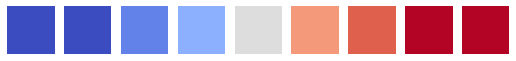

In [9]:
test = [-4.8, -3.8, -2.8, -1.8, 0, 1.8, 2.8, 3.8, 4.8]
rgba_values = []

# Get the 'coolwarm' colormap
cmap = plt.get_cmap('coolwarm', len(test))

for i in test:
    # Map the value 'i' to a color using the colormap
    rgba = cmap((i - min(test)) / (max(test) - min(test)))  # Normalize the value to [0, 1]
    rgba_values.append(rgba)

# Create a 1x9 grid of color boxes
fig, axes = plt.subplots(1, 9, figsize=(9, 2))

for i, rgba in enumerate(rgba_values):
    ax = axes[i]

    # Create a rectangle filled with the specified color
    rectangle = plt.Rectangle((0, 0), 1, 1, fc=rgba)

    # Add the rectangle to the axis
    ax.add_patch(rectangle)

    # Set the aspect ratio to 'equal' so the rectangle appears as a square
    ax.set_aspect('equal')

    # Set axis limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    # Remove axis labels and ticks
    ax.axis('off')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.2)

# Show the grid of color swatches
plt.show()

# Each Type of Plotting Function with Example Usage

In [10]:
################################################################################################################

def plot_slice(X, Y, Z, title):
    # Create a new figure with a specified size
    fig = plt.figure(figsize=(11, 6.5))

    # Get the 'coolwarm' colormap from matplotlib
    cmap = plt.get_cmap('coolwarm')

    # Define a normalization for the color scale based on specified min and max values
    norm = colors.Normalize(vmin=-2, vmax=38)

    # Plot the data using filled contours
    # X, Y, and Z are the data arrays for the x, y, and z dimensions of the plot
    # levels=10 specifies the number of contour levels
    # cmap specifies the colormap to be used
    # norm specifies the normalization for the color scale
    cs = plt.contourf(X, Y, Z, levels=10, cmap=cmap, norm=norm)

    # Add a colorbar to the plot
    # shrink=0.6 reduces the size of the colorbar
    # orientation='horizontal' places the colorbar below the plot
    # label='SST (Celcius)' sets the label for the colorbar
    cbar = plt.colorbar(cs, shrink=0.6, orientation='horizontal', label='SST (Celcius)')

    # Set the title of the plot using the provided 'title' parameter
    plt.title(title)

    # Display the plot
    plt.show()

# Example usage:
# Replace X, Y, and Z with your actual data arrays
# Replace 'Title of the Plot' with your desired plot title
# plot_slice(X, Y, Z, 'Title of the Plot')

################################################################################################################

def plot_projection(X, Y, Z, title):
    # Create a figure with a specified size
    fig = plt.figure(figsize=(11, 6.5))

    # Set the axes using the Robinson projection
    ax = plt.axes(projection=ccrs.Robinson())

    # Set the colormap and normalization
    cmap = plt.get_cmap('coolwarm')
    norm = colors.Normalize(vmin=-2, vmax=38)

    # Add cyclic point to the data for smooth plotting
    # 'Z' is the data, 'coord=X' specifies the X coordinate to be cyclic
    Z, lons = add_cyclic_point(Z, coord=X)

    # Plot the data using filled contours
    # 'lons' are the longitudes after adding cyclic points
    # 'Y' is the y-coordinate, 'Z' is the data
    # 'transform=ccrs.PlateCarree()' specifies the PlateCarree projection for the data
    cs = ax.contourf(lons, Y, Z, levels=10, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)

    # Add coastlines to the plot
    ax.coastlines()

    # Add colorbar to the plot
    # 'shrink=0.6' reduces the size of the colorbar
    # 'orientation='horizontal'' places the colorbar below the plot
    # 'label='SST (Celsius)'' sets the label for the colorbar
    cbar = plt.colorbar(cs, shrink=0.6, orientation='horizontal', label='SST (Celsius)')

    # Set the title of the plot
    plt.title(title)

    # Display the plot
    plt.show()

# Example usage:
# Replace X, Y, and Z with your actual data arrays
# Replace 'Title of the Plot' with your desired plot title
# plot_projection(X, Y, Z, 'Title of the Plot')

################################################################################################################

def scatterplot(X, Y, diff, title, neg95, pos95, med, scatter_X, scatter_Y):
    
    """
    Function to create a combined scatter plot with temperature contour.

    Parameters:
    X (array-like): Array of x-axis values (longitude).
    Y (array-like): Array of y-axis values (depth).
    diff (array-like): Array of temperature differences.
    title (str): Title for the plot.
    neg95 (array-like): Array of values for the negative 95th percentile.
    pos95 (array-like): Array of values for the positive 95th percentile.
    med (array-like): Array of median values.
    scatter_X (array-like): Array of x-axis values for scatter points.
    scatter_Y (array-like): Array of y-axis values for scatter points.
    """

    # Create a figure with a single subplot for both temperature contour and violin plots
    fig, ax = plt.subplots(figsize=(15, 5))

    # Define contour levels and colormap for the temperature contour plot
    contour_levels = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    cmap = plt.get_cmap('coolwarm', 21)  # Choose the 'coolwarm' colormap with 21 levels
    norm = plt.Normalize(vmin=-5, vmax=5)  # Normalize the colormap for specified min and max values

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([0, -800])
    ax.invert_yaxis()

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    # Set labels for the y-axis (depth) and x-axis (longitude)
    ax.set_ylabel("Depth (m)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)

    # Plot the temperature data using contourf with specified contour levels and colormap
    cs = ax.contourf(X, Y, diff, levels=contour_levels, cmap=cmap, norm=norm)

    # Add a colorbar to the temperature contour plot
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', label='Celsius')

    # Scatter points with color coding for negative 95th percentile, median, and positive 95th percentile
    ax.scatter(scatter_X, scatter_Y, c=neg95, marker='o', s=150, cmap=cmap, vmin=-5, vmax=5, edgecolors='k')
    ax.scatter(scatter_X, scatter_Y, c=med, marker='o', s=75, cmap=cmap, vmin=-5, vmax=5)
    ax.scatter(scatter_X, scatter_Y, c=pos95, marker='o', s=15, cmap=cmap, vmin=-5, vmax=5)

    # Set the title for the combined plot
    ax.set_title(title)

    # Set the font size of tick labels on both x and y axes for the combined plot
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    # Display the plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Replace X, Y, diff, title, neg95, pos95, med, scatter_X, and scatter_Y with your actual data arrays
# scatterplot(X, Y, diff, title, neg95, pos95, med, scatter_X, scatter_Y)

################################################################################################################

def violinplot(X, Y, diff, title, pos95, med, neg95, lon_sites, species_sites):
    """
    Function to create a combined plot with temperature contour and violin plots.

    Parameters:
    X (array-like): Array of x-axis values (longitude).
    Y (array-like): Array of y-axis values (depth).
    diff (array-like): Array of temperature differences.
    title (str): Title for the plot.
    pos95 (array-like): Array of values for the positive 95th percentile.
    med (array-like): Array of median values.
    neg95 (array-like): Array of values for the negative 95th percentile.
    lon_sites (array-like): Array of longitude values for sites.
    species_sites (array-like): Array of species names for sites.
    """

    # Create a figure with a single subplot for both temperature contour and violin plots
    fig, ax = plt.subplots(figsize=(15, 5))

    # Define contour levels and colormap for the temperature contour plot
    contour_levels = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    cmap = plt.get_cmap('coolwarm', 21)
    norm = plt.Normalize(vmin=-5, vmax=5)

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([-800, 0])

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    # Set labels for the y-axis (depth) and x-axis (longitude)
    ax.set_ylabel("Depth (m)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)

    # Plot the temperature data using contourf with specified contour levels and colormap
    cs = ax.contourf(X, Y, diff, levels=contour_levels, cmap=cmap, norm=norm)

    # Add a colorbar to the temperature contour plot
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', label='Celsius')

    # Set the title for the combined plot
    ax.set_title(title)

    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    species_sites_noAlks = species_sites[2:]

    # Define custom positions for the violin plots on the x-axis
    xpositions = np.array(lon_sites[2:])

    # Iterate over each site and create violins with specified colors
    for i in range(len(xpositions)):

        # Create the violin plot with a custom color for the negative 95th percentile
        parts = ax.violinplot(-neg95[i], [np.array(xpositions[i])], vert=True, widths=9, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(neg95rgba_values[i])  # Assign the custom color
            pc.set_edgecolor('black')  # Set the edge color to black
            pc.set_alpha(0.3)

        # Create the violin plot with a custom color for the median
        parts1 = ax.violinplot(-med[i], [np.array(xpositions[i])], vert=True, widths=6, showextrema=False)
        for pc in parts1['bodies']:
            pc.set_facecolor(medrgba_values[i])  # Assign the custom color
            pc.set_alpha(0.4)

        # Create the violin plot with a custom color for the positive 95th percentile
        parts2 = ax.violinplot(-pos95[i], [np.array(xpositions[i])], vert=True, widths=2.5, showextrema=False)
        for pc in parts2['bodies']:
            pc.set_facecolor(pos95rgba_values[i])  # Assign the custom color
            pc.set_alpha(1)

    # Show the plot
    plt.show()

# Example usage:
# Replace X, Y, diff, title, pos95, med, neg95, lon_sites, and species_sites with your actual data arrays
# vplot(X, Y, diff, title, pos95, med, neg95, lon_sites, species_sites)

################################################################################################################

alk_sites = dsa.where(dsa['species'] == 'alkenones', drop=True) # This variable is needed to be set before using Combined Plot function

################################################################################################################

def plot(X, Y, diff, title, pos95, med, neg95, lon_sites, species_sites, scatter_X, scatter_Y, scatter_med, scatter_pos95, scatter_neg95):
    """
    Function to create a combined plot with temperature contour, violin plots, and scatter points.

    Parameters:
    X (array-like): Array of x-axis values (longitude).
    Y (array-like): Array of y-axis values (depth).
    diff (array-like): Array of temperature differences.
    title (str): Title for the plot.
    pos95 (array-like): Array of values for the positive 95th percentile.
    med (array-like): Array of median values.
    neg95 (array-like): Array of values for the negative 95th percentile.
    lon_sites (array-like): Array of longitude values for sites.
    species_sites (array-like): Array of species names for sites.
    scatter_X (array-like): Array of x-axis values for scatter points.
    scatter_Y (array-like): Array of y-axis values for scatter points.
    scatter_med (array-like): Array of median values for scatter points.
    scatter_pos95 (array-like): Array of values for the positive 95th percentile for scatter points.
    scatter_neg95 (array-like): Array of values for the negative 95th percentile for scatter points.
    """

    # Create a figure with a single subplot for both temperature contour and violin plots
    fig, ax = plt.subplots(figsize=(15, 5))

    # Define contour levels and colormap for the temperature contour plot
    contour_levels = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    cmap = plt.get_cmap('coolwarm', 21)
    norm = plt.Normalize(vmin=-5, vmax=5)

    # Clip values above 5 to 5 for the temperature differences array
    diff_clipped = np.clip(diff, None, 5)

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([-800, 0])

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(16)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(16)

    # Set labels for the y-axis (depth) and x-axis (longitude)
    ax.set_ylabel("Depth (m)", fontsize=16)
    ax.set_xlabel("Longitude", fontsize=16)

    # Plot the clipped temperature data using contourf with specified contour levels and colormap
    cs = ax.contourf(X, Y, diff_clipped, levels=contour_levels, cmap=cmap, norm=norm)

    # Add a colorbar to the temperature contour plot
    cbar = plt.colorbar(cs, ax=ax, orientation='vertical', label='Celsius')

    # Set the title for the combined plot
    ax.set_title(title)
    
    # Remove alkenones
    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    species_sites_noAlks = species_sites[2:] 

    # Define custom positions for the violin plots on the x-axis
    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    xpositions = np.array(lon_sites[2:])

    # Extract depth data for each species for violin plots
    violin_data = [df_filtered[df_filtered['species'] == species_sites_noAlks[i]]['calc_depth'].values for i in range(len(xpositions))]   

    # Iterate over each site and create violins with specified colors
    for i in range(len(xpositions)):
        
        # Create the violin plot with a custom color for the negative 95th percentile
        parts = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=9, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(neg95rgba_values[i])  # Assign the custom color
            pc.set_edgecolor('black')  # Set the edge color to black
            pc.set_alpha(0.3)
        
        # Create the violin plot with a custom color for the median
        parts1 = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=6, showextrema=False)
        for pc in parts1['bodies']:
            pc.set_facecolor(medrgba_values[i])  # Assign the custom color
            pc.set_alpha(0.4)
        
        # Create the violin plot with a custom color for the positive 95th percentile
        parts2 = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=2.5, showextrema=False)
        for pc in parts2['bodies']:
            pc.set_facecolor(pos95rgba_values[i])  # Assign the custom color
            pc.set_alpha(1)
            
    # Scatter points with color coding for negative 95th percentile, median, and positive 95th percentile
    ax.scatter(
        [scatter_X[0], scatter_X[1]],
        [scatter_Y[0], scatter_Y[1]],
        c=[scatter_neg95[0], scatter_neg95[1]],
        marker='o',
        s=150,
        cmap=cmap,
        vmin=-5,
        vmax=5,
        edgecolors='k'
    )

    ax.scatter(
        [scatter_X[0], scatter_X[1]],
        [scatter_Y[0], scatter_Y[1]],
        c=[scatter_med[0], scatter_med[1]],
        marker='o',
        s=75,
        cmap=cmap,
        vmin=-5,
        vmax=5
    )
    
    ax.scatter(
        [scatter_X[0], scatter_X[1]],
        [scatter_Y[0], scatter_Y[1]],
        c=[scatter_pos95[0], scatter_pos95[1]],
        marker='o',
        s=15,
        cmap=cmap,
        vmin=-5,
        vmax=5
    )

    # Show the plot
    plt.show()

# Example usage:
# Replace X, Y, diff, title, pos95, med, neg95, lon_sites, species_sites, scatter_X, scatter_Y, scatter_med, scatter_pos95, scatter_neg95 with your actual data arrays
# plot(X, Y, diff, title, pos95, med, neg95, lon_sites, species_sites, scatter_X, scatter_Y, scatter_med, scatter_pos95, scatter_neg95)

################################################################################################################

## MULTI-MODEL MEAN

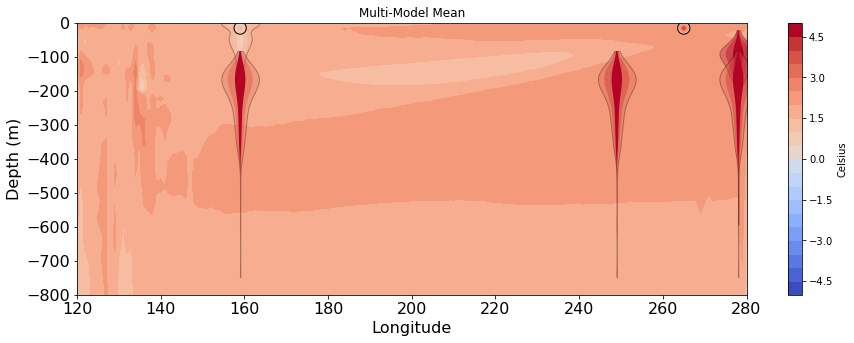

In [11]:
plot(
    multiplio.lon,
    -multiplio['lev'],
    horizontal_difference(multiplio, multipi),
    title="Multi-Model Mean",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #1 CCSM4

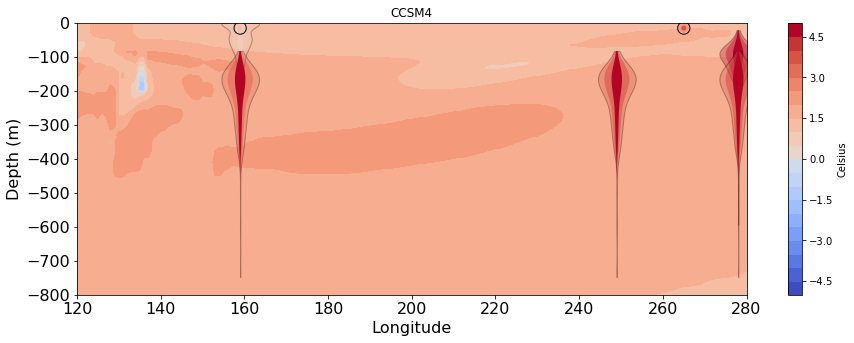

In [19]:
plot(
    pliosds[0].lon,
    -pliosds[0]['lev'],
    horizontal_difference(pliosds[0], pisds[0]),
    title="CCSM4",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #2 CESM 1.2

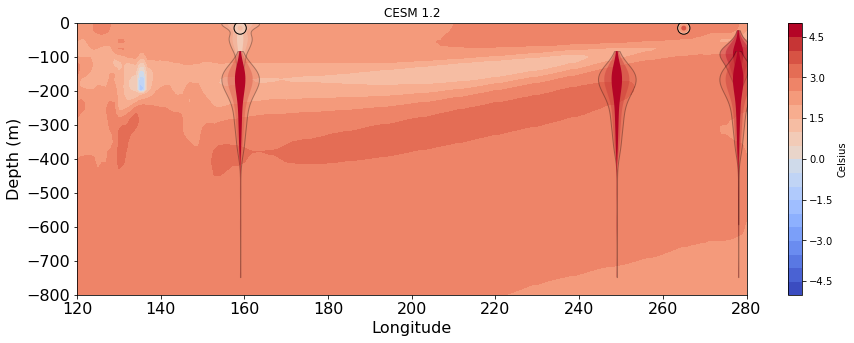

In [12]:
plot(
    pliosds[1].lon,
    -pliosds[1]['lev'],
    horizontal_difference(pliosds[1], pisds[1]),
    title="CESM 1.2",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #3 CESM 2

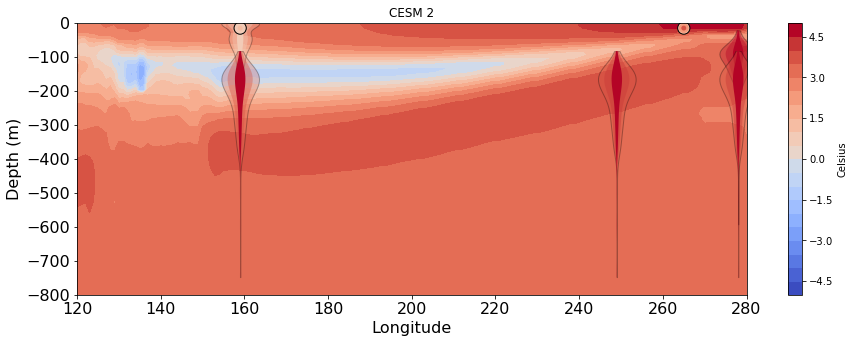

In [104]:
plot(
    pliosds[2].lon,
    -pliosds[2]['lev'],
    horizontal_difference(pliosds[2], pisds[2]),
    title="CESM 2",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #4 COSMOS

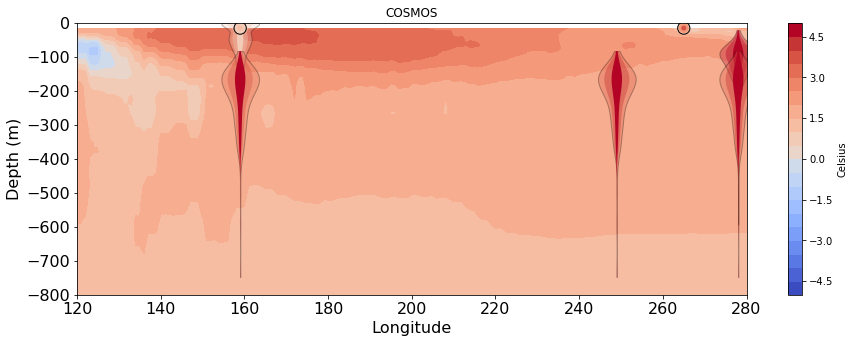

In [58]:
plot(
    pliosds[3].lon,
    -pliosds[3]['lev'],
    horizontal_difference(pliosds[3], pisds[3]),
    title="COSMOS",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #5 EC-Earth 3.3

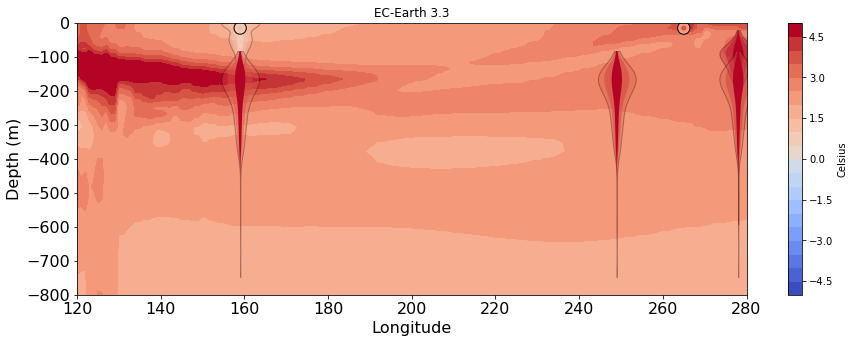

In [127]:
plot(
    pliosds[4].lon,
    -pliosds[4]['lev'],
    horizontal_difference(pliosds[4], pisds[4]),
    title= "EC-Earth 3.3",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #6 HADGEM3 NEW 1997

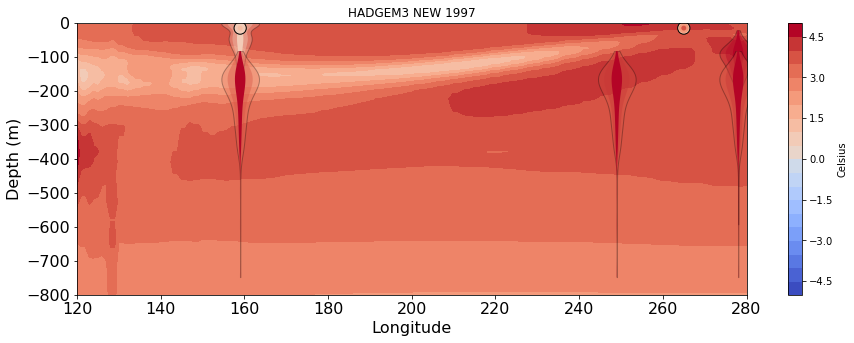

In [34]:
plot(
    pliosds[5].lon,
    -pliosds[5]['lev'],
    horizontal_difference(pliosds[5], pisds[5]),
    title="HADGEM3 NEW 1997",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #7 MIROC4_2004

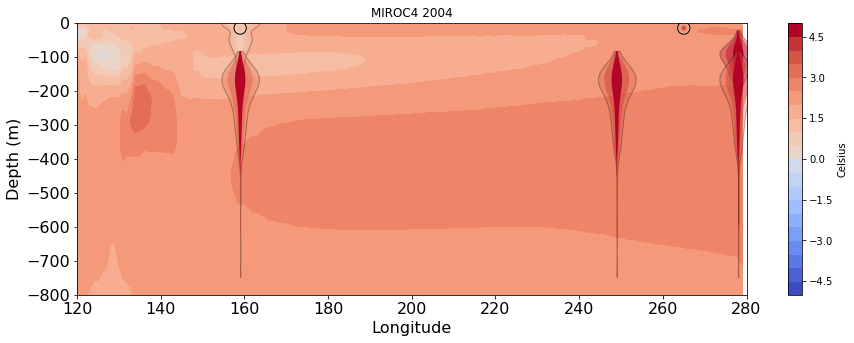

In [33]:
plot(
    pliosds[6].lon,
    -pliosds[6]['lev'],
    horizontal_difference(pliosds[6], pisds[6]),
    title="MIROC4 2004",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #8 Utrecht CESM1.0.5

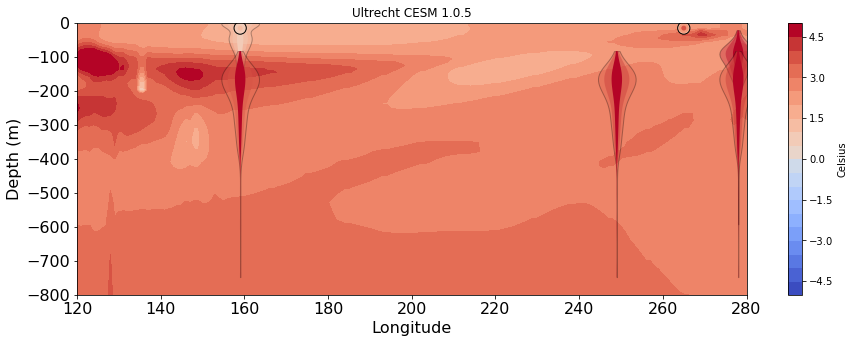

In [35]:
plot(
    pliosds[7].lon,
    -pliosds[7]['lev'],
    horizontal_difference(pliosds[7], pisds[7]),
    title="Ultrecht CESM 1.0.5",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #9 IPSLCM6A_LR

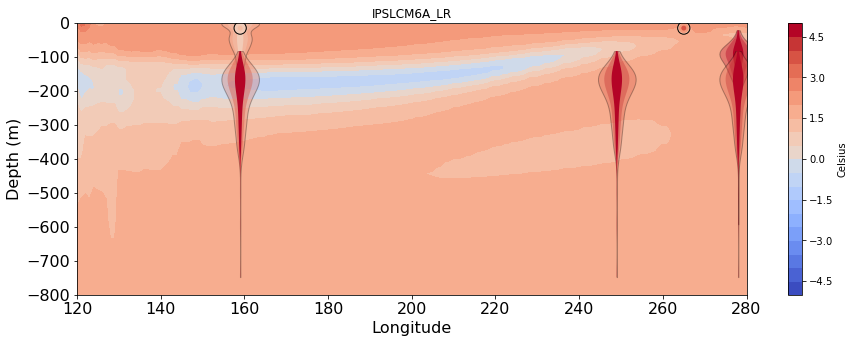

In [36]:
plot(
    pliosds[8].lon,
    -pliosds[8]['lev'],
    horizontal_difference(pliosds[8], pisds[8]),
    title="IPSLCM6A_LR",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #10 GISS

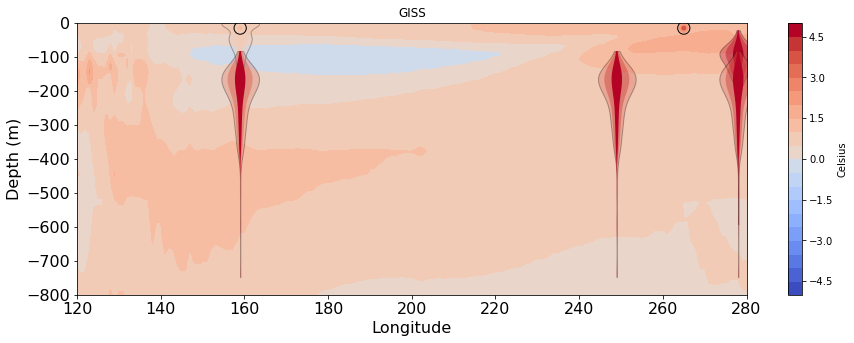

In [37]:
plot(
    pliosds[9].lon,
    -pliosds[9]['lev'],
    horizontal_difference(pliosds[9], pisds[9]),
    title="GISS",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

##  #11 LEEDS

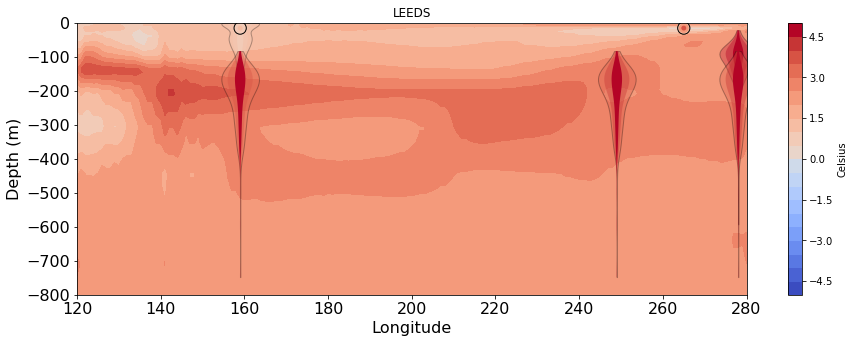

In [38]:
plot(
    pliosds[10].lon,
    -pliosds[10]['lev'],
    horizontal_difference(pliosds[10], pisds[10]),
    title="LEEDS",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #12 NorESM-F

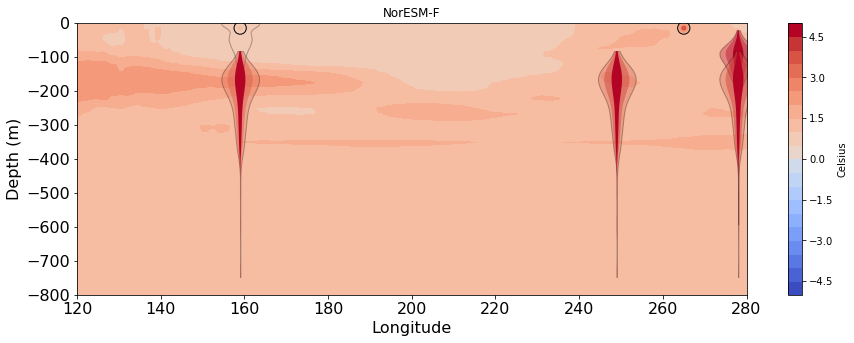

In [39]:
plot(
    pliosds[11].lon,
    -pliosds[11]['lev'],
    horizontal_difference(pliosds[11], pisds[11]),
    title="NorESM-F",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #13 IPSLCM5A

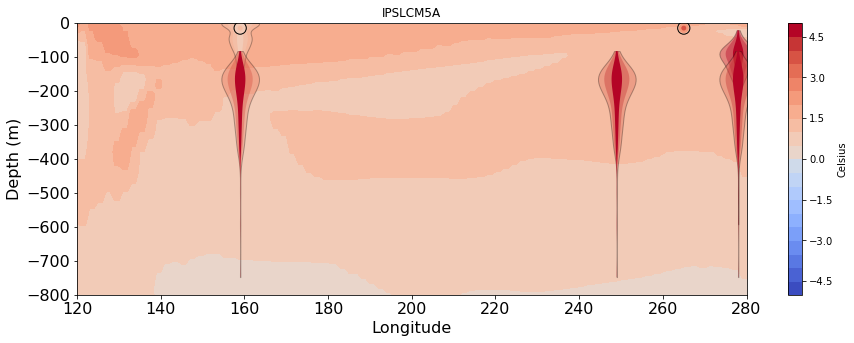

In [40]:
plot(
    pliosds[12].lon,
    -pliosds[12]['lev'],
    horizontal_difference(pliosds[12], pisds[12]),
    title="IPSLCM5A",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

## #14 IPSLCM5A2

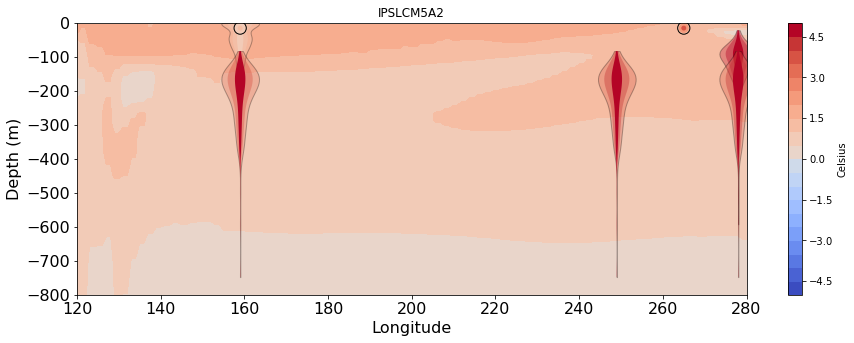

In [41]:
plot(
    pliosds[13].lon,
    -pliosds[13]['lev'],
    horizontal_difference(pliosds[13], pisds[13]),
    title="IPSLCM5A2",
    pos95=dsa['pos95'],
    med=dsa['median'],
    neg95=dsa['neg95'],
    lon_sites=dsa['longitude'],
    species_sites=dsa['species'],
    scatter_X=alk_sites['longitude'],
    scatter_Y=alk_sites['depth'],
    scatter_med=alk_sites['median'], 
    scatter_pos95=alk_sites['pos95'],
    scatter_neg95=alk_sites['neg95'],
)

# FULL 7x2 COMPARISON PLOT

In [12]:
def gridplot(X, Y, diff, title, pos95, med, neg95, lon_sites, species_sites, scatter_X, scatter_Y, scatter_med, scatter_pos95, scatter_neg95, ax=None):
    """
    Function to create a combined plot with temperature contour, violin plots, and scatter points.

    Parameters:
    X (array-like): Array of x-axis values (longitude).
    Y (array-like): Array of y-axis values (depth).
    diff (array-like): Array of temperature differences.
    title (str): Title for the plot.
    pos95 (array-like): Array of values for the positive 95th percentile.
    med (array-like): Array of median values.
    neg95 (array-like): Array of values for the negative 95th percentile.
    lon_sites (array-like): Array of longitude values for sites.
    species_sites (array-like): Array of species names for sites.
    scatter_X (array-like): Array of x-axis values for scatter points.
    scatter_Y (array-like): Array of y-axis values for scatter points.
    scatter_med (array-like): Array of median values for scatter points.
    scatter_pos95 (array-like): Array of values for the positive 95th percentile for scatter points.
    scatter_neg95 (array-like): Array of values for the negative 95th percentile for scatter points.
    ax (matplotlib.axes._subplots.AxesSubplot): Axes on which to plot. If None, a new figure and axis will be created.

    Returns:
    cs (matplotlib.contour.QuadContourSet): Contour set for color mapping.
    """

    # If ax is not provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots(figsize=(18, 12))

    # Define contour levels and colormap for the temperature contour plot
    contour_levels = [-5, -4.5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5]
    cmap = plt.get_cmap('coolwarm', 21)
    norm = plt.Normalize(vmin=-5, vmax=5)

    # Clip values above 5 to 5 for the temperature differences array
    diff_clipped = np.clip(diff, None, 5)

    # Set the y-axis limits and invert it to display depth from top to bottom
    ax.set_ylim([-800, 0])

    # Set the x-axis limits for the temperature contour plot
    ax.set_xlim([120, 280])

    # Set the font size of tick labels on both x and y axes
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(12)

    # Set labels for the y-axis (depth) and x-axis (longitude)
    ax.set_ylabel("Depth (m)", fontsize=10)
    ax.set_xlabel("Longitude", fontsize=10)

    # Plot the clipped temperature data using contourf with specified contour levels and colormap
    cs = ax.contourf(X, Y, diff_clipped, levels=contour_levels, cmap=cmap, norm=norm)

    # Add contour lines specifically for values above 5 with hashmarks
    cs_lines = ax.contour(X, Y, diff, levels=[5], colors='k', linestyles='dashed', linewidths=1)

    # Set the title for the combined plot
    ax.set_title(title)
    
    # Remove alkenones
    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    species_sites_noAlks = species_sites[2:] 

    # Define custom positions for the violin plots on the x-axis
    # Exclude first two sites because they are alkenones for which there is no depth presence distribution
    xpositions = np.array(lon_sites[2:])

    # Extract depth data for each species for violin plots
    violin_data = [df_filtered[df_filtered['species'] == species_sites_noAlks[i]]['calc_depth'].values for i in range(len(xpositions))]   

    # Iterate over each site and create violins with specified colors
    for i in range(len(xpositions)):
        
        # Create the violin plot with a custom color for the negative 95th percentile
        parts = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=9, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(neg95rgba_values[i])  # Assign the custom color
            pc.set_edgecolor('black')  # Set the edge color to black
            pc.set_alpha(0.3)
        
        # Create the violin plot with a custom color for the median
        parts1 = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=6, showextrema=False)
        for pc in parts1['bodies']:
            pc.set_facecolor(medrgba_values[i])  # Assign the custom color
            pc.set_alpha(0.4)
        
        # Create the violin plot with a custom color for the positive 95th percentile
        parts2 = ax.violinplot(-violin_data[i], [np.array(xpositions[i])], vert=True, widths=2.5, showextrema=False)
        for pc in parts2['bodies']:
            pc.set_facecolor(pos95rgba_values[i])  # Assign the custom color
            pc.set_alpha(1)
            
    # Scatter points with color coding for negative 95th percentile, median, and positive 95th percentile
    ax.scatter(
        [scatter_X[0], scatter_X[1]],
        [scatter_Y[0], scatter_Y[1]],
        c=[scatter_neg95[0], scatter_neg95[1]],
        marker='o',
        s=150,
        cmap=cmap,
        vmin=-5,
        vmax=5,
        edgecolors='k'
    )

    ax.scatter(
        [scatter_X[0], scatter_X[1]],
        [scatter_Y[0], scatter_Y[1]],
        c=[scatter_med[0], scatter_med[1]],
        marker='o',
        s=75,
        cmap=cmap,
        vmin=-5,
        vmax=5
    )
    
    ax.scatter(
        [scatter_X[0], scatter_X[1]],
        [scatter_Y[0], scatter_Y[1]],
        c=[scatter_pos95[0], scatter_pos95[1]],
        marker='o',
        s=15,
        cmap=cmap,
        vmin=-5,
        vmax=5
    )

    # If ax is not provided, show the plot
    if ax is None:
        plt.show()
    
    return cs

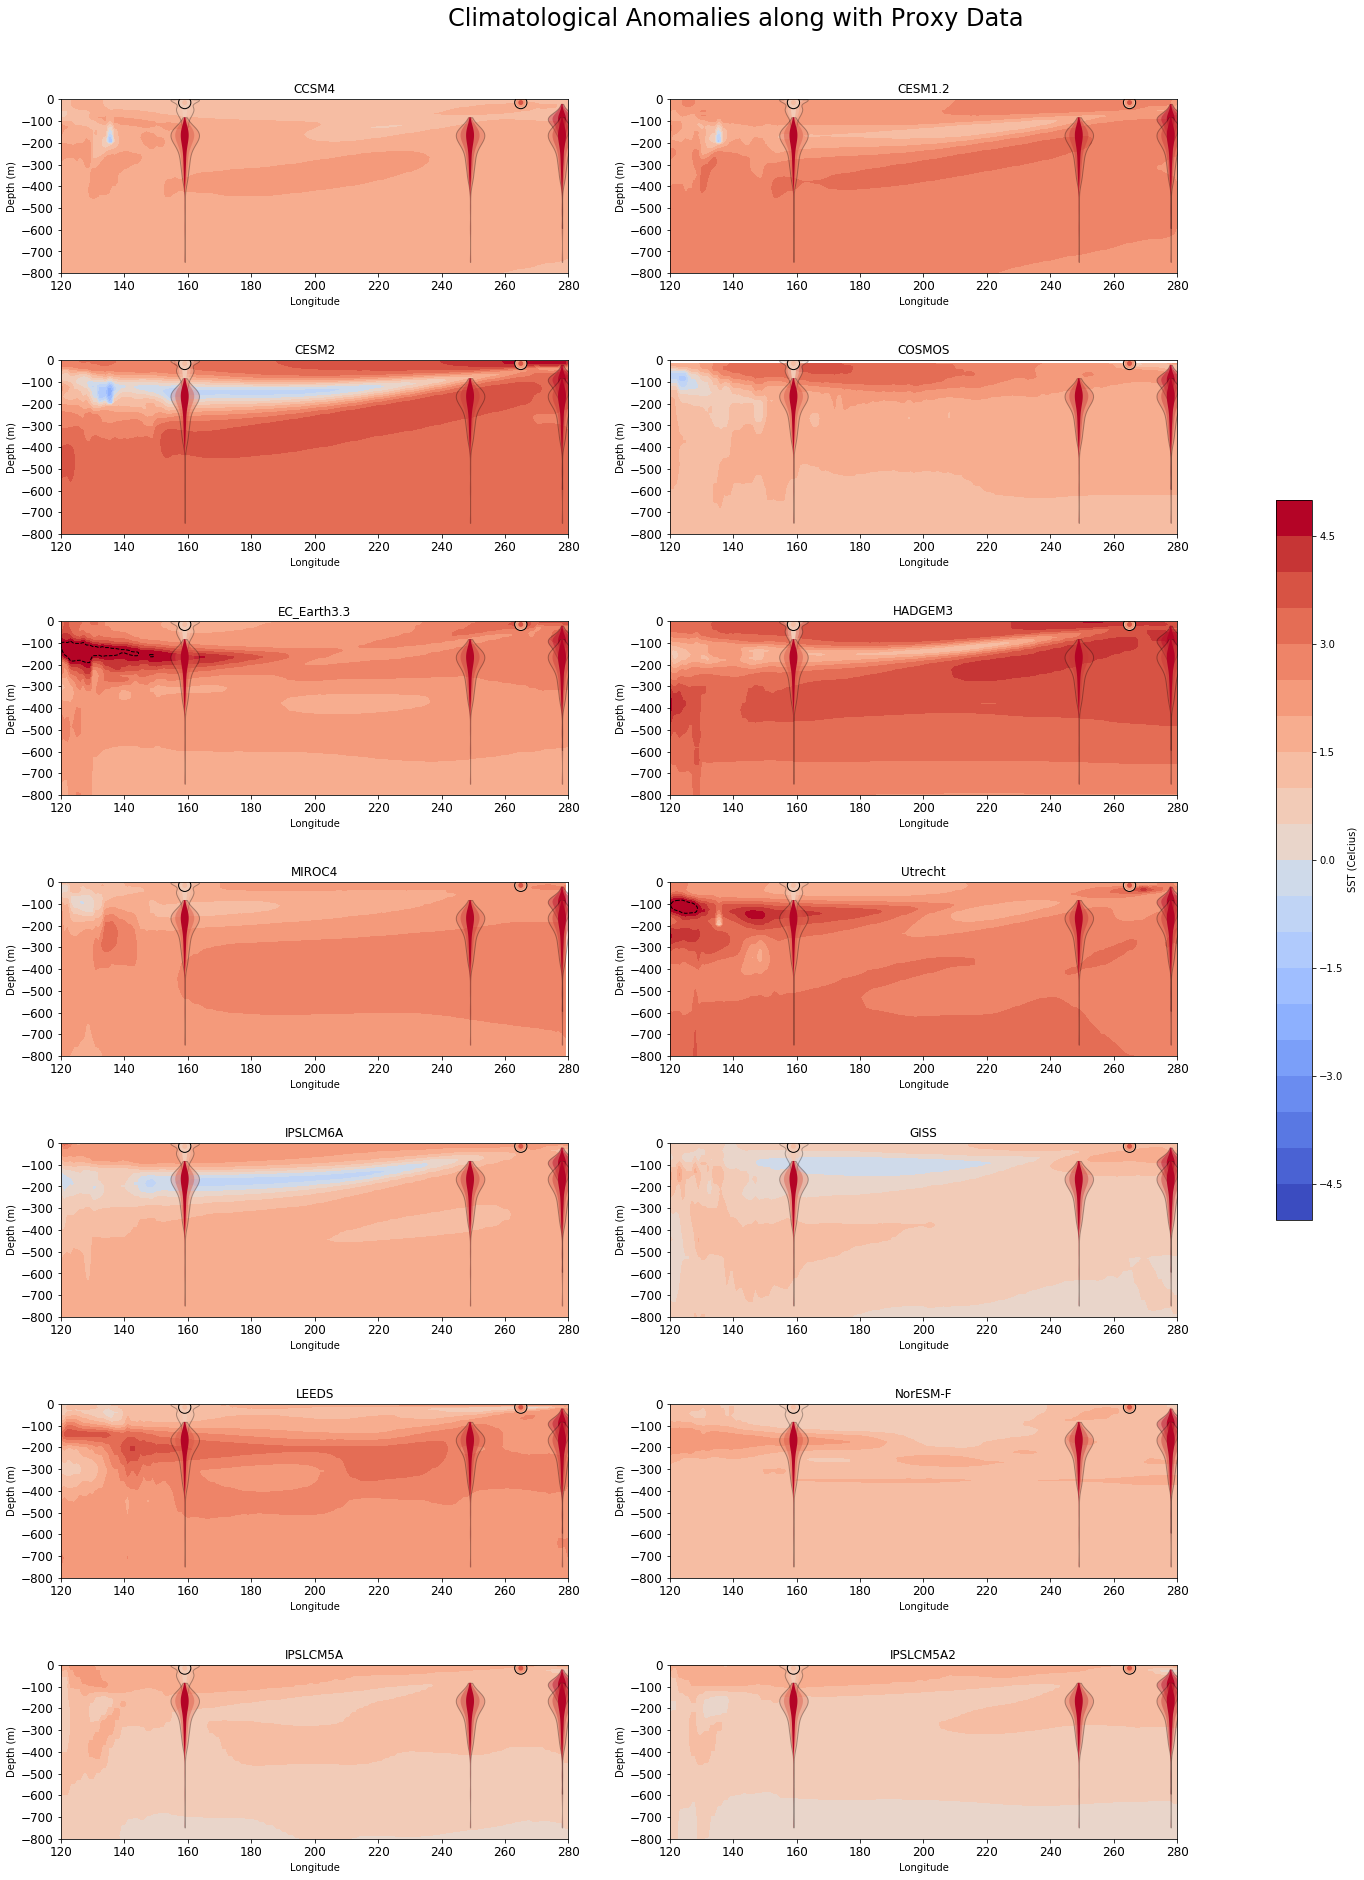

In [25]:
# List of model names
model_names = ['CCSM4', 'CESM1.2', 'CESM2', 'COSMOS', 'EC_Earth3.3', 'HADGEM3', 'MIROC4', 'Utrecht',
               'IPSLCM6A', 'GISS', 'LEEDS', 'NorESM-F', 'IPSLCM5A', 'IPSLCM5A2']

# Create a 7x2 subplot grid with specified figure size and vertical spacing
fig, axes = plt.subplots(7, 2, figsize=(25, 32), gridspec_kw={'hspace': 0.5})

# Flatten the 2D array of axes for easier indexing
axes = axes.flatten()

# Iterate over each model name and corresponding data
for i, model_name in enumerate(model_names):

    # Call your gridplot function with specific arguments for the current model
    cs = gridplot(
        pliosds[i].lon,
        -pliosds[i]['lev'],
        horizontal_difference(pliosds[i], pisds[i]),
        title=model_names[i],
        pos95=dsa['pos95'],
        med=dsa['median'],
        neg95=dsa['neg95'],
        lon_sites=dsa['longitude'],
        species_sites=dsa['species'],
        scatter_X=alk_sites['longitude'],
        scatter_Y=alk_sites['depth'],
        scatter_med=alk_sites['median'], 
        scatter_pos95=alk_sites['pos95'],
        scatter_neg95=alk_sites['neg95'],
        ax=axes[i])

# Create a colorbar for the entire plot
cbar = fig.colorbar(cs, ax=axes, orientation='vertical', label='SST (Celcius)')

# Set an overall title with increased font size
fig.suptitle('Climatological Anomalies along with Proxy Data', fontsize=24, y=0.92)

# Adjust layout to prevent overlapping and move title and colorbar down
plt.tight_layout(rect=[0, 0.08, 1, 0.9])

# Adjust colorbar position
cbar.ax.set_position([0.8, 0.1, 0.02, 0.9])

# Save the figure as a large image file (e.g., PNG)
plt.savefig('realfullplotgrid.png', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

## Creating Anomoly Files

In [23]:
# Define the function to calculate horizontal temperature difference
def h_diff(plio_ds, pi_ds):
    # Calculate the temperature difference between Pliocene and Preindustrial datasets along the latitude axis
    dif = plio_ds - pi_ds
    diff = dif.mean(dim='lat', skipna=True)
    return diff

model_anomalies = []

# Iterate through pliosds and pisds within the specified range
for i in range(14):
    plio_ds = pliosds[i]
    pi_ds = pisds[i]
    # Assuming 'TEMP' is the variable you want to access
    difference_array = h_diff(plio_ds['TEMP'], pi_ds['TEMP'])
    model_anomalies.append(difference_array)
    
# Print the length of the model_anomalies list
print(f"The length of the model_anomalies list is {len(model_anomalies)} models!")

opath = '/glade/u/home/nwrye/OceanTemps_Compiles/Equator Anomaly Files/'
anom_names = ['CCSM4_anomaly.nc', 'CESM1.2_anomaly.nc', 'CESM2_anomaly.nc', 'COSMOS_anomaly.nc',
              'EC_Earth3.3_anomaly.nc', 'HADGEM3_NEW_1997_anomaly.nc','MIROC4_2004_anomaly.nc', 'Utrecht_CESM1.0.5_anomaly.nc',
              'IPSLCM6A_LR_anomaly.nc', 'GISS_anomaly.nc', 'LEEDS_anomaly.nc', 'NorESM-F_anomaly.nc',
              'IPSLCM5A_anomaly.nc', 'IPSLCM5A2_anomaly.nc']

# Check if the directory exists, create if it does not
if not os.path.exists(opath):
    os.makedirs(opath)

for i in range(14):
    model_anomalies[i].to_netcdf(os.path.join(opath, anom_names[i]))

print('Files Saved')

The length of the model_anomalies list is 14 models!
Files Saved


# OPENING ANOMOLY NEWLY CREATED TEMP ANOMOLY FILES

In [42]:
opath = '/glade/u/home/nwrye/OceanTemps_Compiles/Equator Anomaly Files/'
anom_names = ['CCSM4_anomaly.nc', 'CESM1.2_anomaly.nc', 'CESM2_anomaly.nc', 'COSMOS_anomaly.nc',
              'EC_Earth3.3_anomaly.nc', 'HADGEM3_NEW_1997_anomaly.nc','MIROC4_2004_anomaly.nc', 'Utrecht_CESM1.0.5_anomaly.nc',
              'IPSLCM6A_LR_anomaly.nc', 'GISS_anomaly.nc', 'LEEDS_anomaly.nc', 'NorESM-F_anomaly.nc',
              'IPSLCM5A_anomaly.nc', 'IPSLCM5A2_anomaly.nc']
anom_files = []

for i in range(len(anom_names)):
    ds = xr.open_dataset(opath + anom_names[i])
    anom_files.append(ds)
print('Done')

Done


In [45]:
anom_files[0]['TEMP']

<xarray.DataArray 'TEMP' (lev: 43, lon: 360)>
array([[1.501532, 1.504079, 1.510293, ..., 1.510042, 1.503663, 1.501132],
       [1.503216, 1.505859, 1.512079, ..., 1.51207 , 1.505626, 1.503024],
       [1.524453, 1.526816, 1.530132, ..., 1.531345, 1.525729, 1.524142],
       ...,
       [1.833727, 1.835614, 1.837134, ..., 1.826332, 1.829091, 1.831558],
       [1.880733, 1.884151, 1.88707 , ..., 1.867995, 1.872654, 1.8769  ],
       [1.940259, 1.945313, 1.949658, ..., 1.921845, 1.928479, 1.934622]])
Coordinates:
  * lev      (lev) float32 5.0 15.0 25.0 35.0 ... 1106.2042 1244.5669 1400.4972
  * lon      (lon) int64 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359

# STATISTICAL ANALYSIS

### Mean Squared Error Analysis

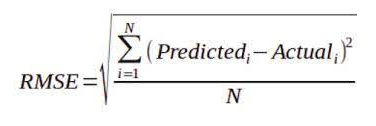

In [30]:
def calculate_rmse(dsmulti, proxy_depth, proxy_lon, alk_sites):
    # Loop through the given proxy locations
    model_TEMP = []
    for i in range(len(proxy_lon)):
        # Find TEMP data variable at each index of proxy_depth and proxy_lon
        TEMP_values = dsmulti.sel(lev=proxy_depth[i], lon=proxy_lon[i])
        model_TEMP.append(TEMP_values.values.item())  # Extracting the temperature value as a Python float

    # Convert scalar proxymed to a single-element array
    proxymed_array = np.array([alk_sites['median'][0]])
    proxypos_array = np.array([alk_sites['pos95'][0]])
    proxyneg_array = np.array([alk_sites['neg95'][0]])

    # Calculate the Root Mean Squared Error (RMSE) for each comparison
    rmse_med = mean_squared_error(model_TEMP, proxymed_array)
    rmse_neg = mean_squared_error(model_TEMP, proxyneg_array)
    rmse_pos = mean_squared_error(model_TEMP, proxypos_array)

    # Print the results
    print(f"Mean Squared Error for model_TEMP vs proxy_medTEMP: {rmse_med}")
    print(f"Mean Squared Error for model_TEMP vs proxy_negTEMP: {rmse_neg}")
    print(f"Mean Squared Error for model_TEMP vs proxy_posTEMP: {rmse_pos}")

# Calculate the temperature difference between the two datasets
dsmulti = horizontal_difference(multiplio, multipi)

# Given proxy_depth values and proxy_lon for the first location
proxy_depth = [15]
proxy_lon = [159]

print('Alk at Longitude = 159 in Multi-Model Mean')
calculate_rmse(dsmulti, proxy_depth, proxy_lon, alk_sites)

# Calculate the temperature difference between the two datasets
dsmulti = horizontal_difference(multiplio, multipi)

# Given proxy_depth values and proxy_lon for the second location
proxy_depth = [15]
proxy_lon = [265]

print('Alk at Longitude = 265 in Multi-Model Mean')

calculate_rmse(dsmulti, proxy_depth, proxy_lon, alk_sites)

Alk at Longitude = 159 in Multi-Model Mean
Mean Squared Error for model_TEMP vs proxy_medTEMP: 0.24215405758430217
Mean Squared Error for model_TEMP vs proxy_negTEMP: 0.3651728364825847
Mean Squared Error for model_TEMP vs proxy_posTEMP: 4.260843751923509
Alk at Longitude = 265 in Multi-Model Mean
Mean Squared Error for model_TEMP vs proxy_medTEMP: 0.10162111151841315
Mean Squared Error for model_TEMP vs proxy_negTEMP: 0.604671358753599
Mean Squared Error for model_TEMP vs proxy_posTEMP: 3.5753904299081376


# RMSE Values for Temperature Anomalies for Alkenones at 265 Longitude

In [130]:
# Given proxy values and proxy_lon for the location
proxy_lon_values = [265]
proxy_depth_values = [15]

# List to store temperature values for each file
model_TEMP_list = []

# Loop through each file in the anom_files list
for anom_file in anom_files:
    # List to store temperature values for the current file
    model_TEMP = []

    # Loop through each lon and lev pair
    for lon_value, depth_value in zip(proxy_lon_values, proxy_depth_values):
        # Find TEMP data variable at the specified lon and lev for the current file
        TEMP_values = anom_file.sel(lon=lon_value, lev=depth_value)['TEMP']
        model_TEMP.append(TEMP_values.values.item())

    # Append the list of temperature values for the current file to the overall list
    model_TEMP_list.append(model_TEMP)

# Proxy values
proxymed_array = np.array([alk_sites['median'][0]])
proxypos_array = np.array([alk_sites['pos95'][0]])
proxyneg_array = np.array([alk_sites['neg95'][0]])

# Lists to store RMSE values
rmse_med_list = []
rmse_neg_list = []
rmse_pos_list = []

# Loop through each file and calculate RMSE values
for i, model_TEMP in enumerate(model_TEMP_list):
    # Check if the lengths are consistent
    if len(model_TEMP) != 1:
        print(f"Error: Inconsistent lengths for model_TEMP and proxymed in file {i + 1}")
        continue  # Skip this iteration

    # Calculate RMSE values
    rmse_med = mean_squared_error(model_TEMP, proxymed_array)
    rmse_neg = mean_squared_error(model_TEMP, proxyneg_array)
    rmse_pos = mean_squared_error(model_TEMP, proxypos_array)

    # Append RMSE values to the lists
    rmse_med_list.append(rmse_med)
    rmse_neg_list.append(rmse_neg)
    rmse_pos_list.append(rmse_pos)

# Print the results in a tabular format
print("| File | RMSE (Median) | RMSE (Negative 95th Percentile) | RMSE (Positive 95th Percentile) |")
print("|------|---------------|---------------------------------|---------------------------------|")

for i in range(len(model_TEMP_list)):
    print(f"| {model_names[i]} | {rmse_med_list[i]:.4f} | {rmse_neg_list[i]:.4f} | {rmse_pos_list[i]:.4f} |")


| File | RMSE (Median) | RMSE (Negative 95th Percentile) | RMSE (Positive 95th Percentile) |
|------|---------------|---------------------------------|---------------------------------|
| CCSM4 | 1.0042 | 0.0089 | 6.6266 |
| CESM1.2 | 0.1142 | 2.0572 | 1.5232 |
| CESM2 | 4.7895 | 10.7905 | 0.3800 |
| COSMOS | 2.3302 | 0.1850 | 9.6013 |
| EC_Earth3.3 | 1.8168 | 5.9745 | 0.0503 |
| HADGEM3 | 3.2516 | 8.4077 | 0.0534 |
| MIROC4 | 0.0070 | 1.0255 | 2.7416 |
| Utrecht | 0.0831 | 0.6532 | 3.4607 |
| IPSLCM6A | 0.2128 | 0.4034 | 4.1346 |
| GISS | 1.4598 | 0.0125 | 7.7301 |
| LEEDS | 5.1070 | 1.3537 | 14.6840 |
| NorESM-F | 1.0919 | 0.0026 | 6.8488 |
| IPSLCM5A | 1.0808 | 0.0032 | 6.8210 |
| IPSLCM5A2 | 1.5030 | 0.0168 | 7.8292 |


| File      | RMSE (Median) | RMSE (Negative 95th Percentile) | RMSE (Positive 95th Percentile) |
|-----------|---------------|---------------------------------|---------------------------------|
| CCSM4     | 1.0042        | 0.0089                          | 6.6266                          |
| CESM1.2   | 0.1142        | 2.0572                          | 1.5232                          |
| CESM2     | 4.7895        | 10.7905                         | 0.3800                          |
| COSMOS    | 2.3302        | 0.1850                          | 9.6013                          |
| EC_Earth3.3| 1.8168        | 5.9745                          | 0.0503                          |
| HADGEM3   | 3.2516        | 8.4077                          | 0.0534                          |
| MIROC4    | 0.0070        | 1.0255                          | 2.7416                          |
| Utrecht   | 0.0831        | 0.6532                          | 3.4607                          |
| IPSLCM6A  | 0.2128        | 0.4034                          | 4.1346                          |
| GISS      | 1.4598        | 0.0125                          | 7.7301                          |
| LEEDS     | 5.1070        | 1.3537                          | 14.6840                         |
| NorESM-F  | 1.0919        | 0.0026                          | 6.8488                          |
| IPSLCM5A  | 1.0808        | 0.0032                          | 6.8210                          |
| IPSLCM5A2 | 1.5030        | 0.0168                          | 7.8292                          |
| MMM       | 0.1016        | 0.6046                          | 3.5753                          |


In [131]:
proxy_lon_values = [159]
proxy_depth_values = [15]

model_TEMP_list = []

# Loop through each file in the anom_files list
for anom_file in anom_files:
    # List to store temperature values for the current file
    model_TEMP = []

    # Loop through each lon and lev pair
    for lon_value, depth_value in zip(proxy_lon_values, proxy_depth_values):
        # Find TEMP data variable at the specified lon and lev for the current file
        TEMP_values = anom_file.sel(lon=lon_value, lev=depth_value)['TEMP']
        model_TEMP.append(TEMP_values.values.item())

    # Append the list of temperature values for the current file to the overall list
    model_TEMP_list.append(model_TEMP)

rmse_med_list = []
rmse_neg_list = []
rmse_pos_list = []

for i, model_TEMP in enumerate(model_TEMP_list):
    # Check if the lengths are consistent
    if len(model_TEMP) != 1:
        print(f"Error: Inconsistent lengths for model_TEMP and proxymed in file {i + 1}")
        continue  # Skip this iteration

    # Convert scalar proxymed to a single-element array
    proxymed_array = np.array([proxymed[0]])
    proxyneg_array = np.array([proxyneg95[0]])
    proxypos_array = np.array([proxypos95[0]])

    rmse_med = mean_squared_error(model_TEMP, proxymed_array)
    rmse_neg = mean_squared_error(model_TEMP, proxyneg_array)
    rmse_pos = mean_squared_error(model_TEMP, proxypos_array)

    rmse_med_list.append(rmse_med)
    rmse_neg_list.append(rmse_neg)
    rmse_pos_list.append(rmse_pos)

print("| File | RMSE (Median) | RMSE (Negative 95th Percentile) | RMSE (Positive 95th Percentile) |")
print("|------|---------------|---------------------------------|---------------------------------|")

for i in range(len(model_TEMP_list)):
    print(f"| {model_names[i]} | {rmse_med_list[i]:.4f} | {rmse_neg_list[i]:.4f} | {rmse_pos_list[i]:.4f} |")

print("| Average | {:.4f} | {:.4f} | {:.4f} |".format(average_rmse_med, average_rmse_neg, average_rmse_pos))

| File | RMSE (Median) | RMSE (Negative 95th Percentile) | RMSE (Positive 95th Percentile) |
|------|---------------|---------------------------------|---------------------------------|
| CCSM4 | 1.3836 | 0.0064 | 7.5534 |
| CESM1.2 | 0.0743 | 0.6786 | 3.4029 |
| CESM2 | 0.3848 | 2.9471 | 0.9059 |
| COSMOS | 0.9923 | 4.3787 | 0.3317 |
| EC_Earth3.3 | 0.2843 | 0.3172 | 4.4322 |
| HADGEM3 | 1.5912 | 5.5593 | 0.0965 |
| MIROC4 | 0.3044 | 0.2967 | 4.5106 |
| Utrecht | 0.5114 | 0.1454 | 5.2313 |
| IPSLCM6A | 0.0043 | 1.0623 | 2.6824 |
| GISS | 3.4544 | 0.5810 | 11.7696 |
| LEEDS | 1.2519 | 0.0005 | 7.2413 |
| NorESM-F | 3.0201 | 0.4115 | 10.9558 |
| IPSLCM5A | 0.7343 | 0.0574 | 5.9000 |
| IPSLCM5A2 | 0.7750 | 0.0467 | 6.0143 |
| Average | 1.0547 | 5.0734 | 1.1778 |


# RMSE Values for Temperature Anomalies for Alkenones at 159 Longitude

| File | RMSE (Median) | RMSE (Negative 95th Percentile) | RMSE (Positive 95th Percentile) |
|------|---------------|---------------------------------|---------------------------------|
| CCSM4 | 1.3836 | 0.0064 | 7.5534 |
| CESM1.2 | 0.0743 | 0.6786 | 3.4029 |
| CESM2 | 0.3848 | 2.9471 | 0.9059 |
| COSMOS | 0.9923 | 4.3787 | 0.3317 |
| EC_Earth3.3 | 0.2843 | 0.3172 | 4.4322 |
| HADGEM3 | 1.5912 | 5.5593 | 0.0965 |
| MIROC4 | 0.3044 | 0.2967 | 4.5106 |
| Utrecht | 0.5114 | 0.1454 | 5.2313 |
| IPSLCM6A | 0.0043 | 1.0623 | 2.6824 |
| GISS | 3.4544 | 0.5810 | 11.7696 |
| LEEDS | 1.2519 | 0.0005 | 7.2413 |
| NorESM-F | 3.0201 | 0.4115 | 10.9558 |
| IPSLCM5A | 0.7343 | 0.0574 | 5.9000 |
| IPSLCM5A2 | 0.7750 | 0.0467 | 6.0143 |
| MMM         | 0.2421        | 0.3651                          | 4.2608                          |

### Bias Under/Over Estimate Analysis

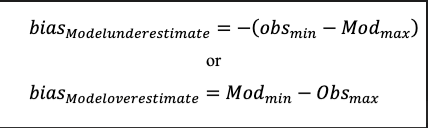

##### Finding max and min depth values for each species in depth distributions (model over/under estimate)

In [132]:
# Extract longitude data from the DataFrame
lon_sites = dsa['longitude'] 

# Exclude first two sites (alkenones) as there is no depth presence distribution for them
xpositions = np.array(lon_sites[2:])
print(xpositions)

# Extract species data from the DataFrame
species_sites = dsa['species']

# Remove alkenones from species data
# Exclude first two sites (alkenones) as there is no depth presence distribution for them
species_sites_noAlks = species_sites[2:] 
print(species_sites_noAlks)
    
# Create a list of arrays where each array contains 'calc_depth' values for a specific species
violin_data = [df_filtered[df_filtered['species'] == species_sites_noAlks[i]]['calc_depth'].values for i in range(len(xpositions))] 

# Initialize empty lists for minimum and maximum values
min_values = []
max_values = []

# Loop through each indexed array in violin_data
for data_array in violin_data:
    # Find minimum and maximum values for the current array
    min_values.append(np.round(np.min(data_array), 2))
    max_values.append(np.round(np.max(data_array), 2))

# Print or use the results as needed
print("Minimum Values for Each Species Array:", min_values)
print("Maximum Values for Each Species Array:", max_values)

[159. 278. 159. 249. 278.]
<xarray.DataArray 'species' (index: 5)>
array(['sacculifer', 'dutertrei', 'tumida', 'tumida', 'tumida'],
      dtype='<U10')
Coordinates:
  * index    (index) int64 2 3 4 5 6
Minimum Values for Each Species Array: [0.0, 21.35, 82.7, 82.7, 82.7]
Maximum Values for Each Species Array: [232.27, 592.43, 747.84, 747.84, 747.84]


##### Testing my method of extracting TEMP values in min, max depth range and at specific longitude

In [133]:
# Extract the first element from pliosds (assuming it's a list of xarray datasets)
depth_sliced = anom_files[0].sel(lon=xpositions[0]).sel(lev=slice(min_values[0], max_values[0]))
depth_sliced['TEMP']

<xarray.DataArray 'TEMP' (lev: 22)>
array([1.25727 , 1.257931, 1.258909, 1.263086, 1.272314, 1.292699, 1.343249,
       1.434502, 1.562442, 1.716245, 1.872496, 1.984479, 2.022214, 1.993192,
       1.936654, 1.889092, 1.867408, 1.862628, 1.85657 , 1.83733 , 1.809529,
       1.792428])
Coordinates:
  * lev      (lev) float32 5.0 15.0 25.0 35.0 ... 197.66026 209.71138 222.57828
    lon      int64 159

##### Looping through each anomoly file at each x position to retrieve the TEMP data at each desired location

In [134]:
d_sliced = []
for i in range(len(anom_files)):
    # Loop through each xposition
    for j in range(len(xpositions)):
        # Select data based on longitude and depth range
        depth_sliced = anom_files[i].sel(lon=xpositions[j]).sel(lev=slice(min_values[j], max_values[j]))
        d_sliced.append(depth_sliced)
"""
we expect d_sliced to have an index = 70 because there are 14 models and 5 species to evaluate with each output
"""    
print((len(d_sliced)))

70


##### Sorting the same longitude (aka species locations) for analysis

In [135]:
sorted_data = {}

for i in range(len(xpositions)):
    lon = xpositions[i]
    lon_data = [depth_sliced for depth_sliced in d_sliced if depth_sliced.lon == lon]
    sorted_data[lon] = lon_data
    
"""
The first 14 in the sorted_data[278][0-13] is the duteri array's and the last 14 [14-27] 
are for the last tumida species as they both are located at lon = 278
Same goes for the lon = 159 as sacclifer and tumida also share a location

I deal with this later with the format of...
first_14_elements = lon_278_data[:14]
last_14_elements = lon_278_data[-14:]
"""
sorted_data[278][0]

<xarray.Dataset>
Dimensions:  (lev: 33)
Coordinates:
  * lev      (lev) float32 25.0 35.0 45.0 55.0 ... 482.7367 527.72797 579.37286
    lon      int64 278
Data variables:
    TEMP     (lev) float64 ...

In [136]:
# Access the data for longitude 278 from the sorted_data dictionary
lon_278_data = sorted_data[278]

# Access the data for longitude 249 from the sorted_data dictionary
tumida_249 = sorted_data[249]

# Access the data for longitude 159 from the sorted_data dictionary
lon_159_data = sorted_data[159]

# Extract the first 14 elements of the data for longitude 159
sacc_159 = lon_159_data[:14]

# Extract the last 14 elements of the data for longitude 159
tumida_159 = lon_159_data[-14:]

# Extract the first 14 elements of the data for longitude 278
duteri_278 = lon_278_data[:14]

# Extract the last 14 elements of the data for longitude 278
tumida_278 = lon_278_data[-14:]

# Print the length of the duteri_278 list
print(len(duteri_278))

# Print the length of the tumida_278 list
print(len(tumida_278))

# Print the length of the tumida_249 list
print(len(tumida_249))

# Print the length of the tumida_159 list
print(len(tumida_159))

# Print the length of the sacc_159 list
print(len(sacc_159))

14
14
14
14
14


##### Extracting Max and Min 

In [158]:
# Function to process dataset and extract min and max values
def process_dataset(dataset, variable_name='TEMP'):
    min_max_dict = {'min_temp': [], 'max_temp': []}

    # Iterate through the dataset
    for i in range(len(dataset)):
        # Extract the specified variable
        temp_variable = dataset[i][variable_name]

        # Calculate min and max values
        min_temp = temp_variable.min().values
        max_temp = temp_variable.max().values

        # Append to the dictionary
        min_max_dict['min_temp'].append(min_temp)
        min_max_dict['max_temp'].append(max_temp)

    # Create an xarray dataset
    min_max_dataset = xr.Dataset(min_max_dict)
    return min_max_dataset

# Assuming tumida_159, duteri_278, sacc_159, tumida_278, tumida_249 are defined datasets

# List of model names
model_names = ['CCSM4', 'CESM1.2', 'CESM2', 'COSMOS', 'EC_Earth3.3', 'HADGEM3', 'MIROC4', 'Utrecht',
               'IPSLCM6A', 'GISS', 'LEEDS', 'NorESM-F', 'IPSLCM5A', 'IPSLCM5A2']

# Process each dataset
tumida_159_min_max_dataset = process_dataset(tumida_159)
duteri_278_min_max_dataset = process_dataset(duteri_278)
sacc_159_min_max_dataset = process_dataset(sacc_159)
tumida_278_min_max_dataset = process_dataset(tumida_278)
tumida_249_min_max_dataset = process_dataset(tumida_249)

# Function to extract min and max values from a dataset
def extract_min_max(dataset):
    min_values = dataset['min_temp'].values.tolist()
    max_values = dataset['max_temp'].values.tolist()
    return min_values, max_values

# Extract min and max values for each dataset
tumida_159_min_values, tumida_159_max_values = extract_min_max(tumida_159_min_max_dataset)
duteri_278_min_values, duteri_278_max_values = extract_min_max(duteri_278_min_max_dataset)
sacc_159_min_values, sacc_159_max_values = extract_min_max(sacc_159_min_max_dataset)
tumida_278_min_values, tumida_278_max_values = extract_min_max(tumida_278_min_max_dataset)
tumida_249_min_values, tumida_249_max_values = extract_min_max(tumida_249_min_max_dataset)

# Print the extracted values
print("Tumida_159 Min Values:", tumida_159_min_values)
print("Tumida_159 Max Values:", tumida_159_max_values)

print("Duteri_278 Min Values:", duteri_278_min_values)
print("Duteri_278 Max Values:", duteri_278_max_values)

print("Sacc_159 Min Values:", sacc_159_min_values)
print("Sacc_159 Max Values:", sacc_159_max_values)

print("Tumida_278 Min Values:", tumida_278_min_values)
print("Tumida_278 Max Values:", tumida_278_max_values)

print("Tumida_249 Min Values:", tumida_249_min_values)
print("Tumida_249 Max Values:", tumida_249_max_values)

Tumida_159 Min Values: [1.7102458477020264, 2.5897305011749268, -0.566079318523407, -0.566079318523407, -0.23299999237060548, -0.23299999237060548, 1.255829450945889, 1.503976191645083, 0.6771957159329454, 0.6991812613149875, 0.9676206707954407, 0.47493189573287964, 0.6302093267440796, 0.2875540852546692]
Tumida_159 Max Values: [4.125283241271973, 4.125283241271973, 2.372105360031128, 2.1384804248809814, 0.5794769287109375, 1.1014949506661478, 3.533729013772677, 3.533729013772677, 2.2081127979302813, 2.2081127979302813, 1.6623153686523438, 1.6623153686523438, 1.6085059642791748, 1.5996567010879517]
Duteri_278 Min Values: [1.1747962951660156, 1.4347673416137696, 2.0401554107666016, 2.4151504039764404, 2.186030149459839, 2.9164347648620605, 1.0171081542968743, 1.4325311916596006, 2.005859851837158, 1.735296607017517, 3.2406453723197686, 2.8187895838821877, 2.330162239074707, 2.3407549285888676]
Duteri_278 Max Values: [1.873235321044922, 1.873235321044922, 2.8341269493103027, 2.8341269493

##### Defining BIAS function for analysis

In [157]:
def Bias(o_min, m_max, o_max, m_min):
    # Calculate the differences
    diff1 = o_max - m_max
    diff2 = m_min - o_max
    
    # Check conditions and calculate prbias
    if diff1 > 0:
        prbias = -diff1
    elif diff2 > 0:
        prbias = diff2
    elif np.isnan(diff1) or np.isnan(diff2):
        prbias = np.nan
    else:
        prbias = 0
    
    return prbias

##### Making sure the function works with random values

In [13]:
def Bias(o_min, m_max, o_max, m_min):
    # Calculate the differences
    diff1 = o_max - m_max
    diff2 = m_min - o_max
    
    # Debugging: Print the values of diff1 and diff2
    print(f"diff1: {diff1}, diff2: {diff2}")
    
    # Check conditions and calculate prbias
    if diff1 > 0:
        prbias = -diff1
        print(f"Condition 1: prbias = {prbias}")
    elif diff2 > 0:
        prbias = diff2
        print(f"Condition 2: prbias = {prbias}")
    elif np.isnan(diff1) or np.isnan(diff2):
        prbias = np.nan
        print("Condition 3: prbias = NaN")
    else:
        prbias = 0
        print("Condition 4: prbias = 0")
    
    return prbias

# Test the function with some example values
o_min = 1.33780378
m_max = 1.683818
o_max = 4.00628024
m_min = 1.404792 

result = Bias(o_min, m_max, o_max, m_min)
print(f"Result: {result}")

diff1: 2.3224622399999997, diff2: -2.6014882399999997
Condition 1: prbias = -2.3224622399999997
Result: -2.3224622399999997


##### Setting the variables for proxy 95% CL

In [141]:
proxy_negTEMP = dsa['neg95']
proxy_posTEMP = dsa['pos95']

print(proxy_negTEMP)
print(proxy_posTEMP)

<xarray.DataArray 'neg95' (index: 7)>
array([1.33780378, 0.80677545, 0.98804171, 5.79925769, 3.44058895,
       3.5751527 , 3.6777151 ])
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6
<xarray.DataArray 'pos95' (index: 7)>
array([4.00628024, 1.32582657, 0.89449334, 7.79089076, 4.65803792,
       4.72592124, 5.48900249])
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6


## Bias Tables

In [164]:
# Define a function for bias analysis
def perform_bias_analysis(model_names, min_values, max_values, proxy_neg_temp, proxy_pos_temp, title):
    table_data = []

    for i in range(len(model_names)):
        prbias = Bias(
            o_min=proxy_neg_temp[2],
            m_max=max_values[i],
            o_max=proxy_pos_temp[2],
            m_min=min_values[i]
        )
        table_data.append([model_names[i], prbias])

    headers = ["Model", "Bias"]

    print(f"\n{title}\n")

    if 'Bias' not in globals():
        print("Error: Bias class not defined!")
    elif any(var is None for var in [min_values, max_values, proxy_neg_temp, proxy_pos_temp, model_names]):
        print("Error: One or more required variables are not defined!")
    else:
        print(tabulate(table_data, headers, tablefmt="fancy_grid"))

# Assuming sacc_159_min_values, sacc_159_max_values, proxy_negTEMP, proxy_posTEMP, and model_names are defined
# Perform bias analysis for Sacculifer
perform_bias_analysis(model_names, sacc_159_min_values, sacc_159_max_values, proxy_negTEMP, proxy_posTEMP, "Sacculifer Bias Analysis for Models")

# Assuming duteri_278_min_values, duteri_278_max_values, proxy_negTEMP, proxy_posTEMP, and model_names are defined
# Perform bias analysis for Dutertrei
perform_bias_analysis(model_names, duteri_278_min_values, duteri_278_max_values, proxy_negTEMP, proxy_posTEMP, "Dutertrei Bias Analysis for Models")

# Assuming tumida_249_min_values, tumida_249_max_values, proxy_negTEMP, proxy_posTEMP, and model_names are defined
# Perform bias analysis for Tumida at 249 Longitude
perform_bias_analysis(model_names, tumida_249_min_values, tumida_249_max_values, proxy_negTEMP, proxy_posTEMP, "Tumida at 249 Longitude Bias Analysis for Models")

# Assuming tumida_278_min_values, tumida_278_max_values, proxy_negTEMP, proxy_posTEMP, and model_names are defined
# Perform bias analysis for Tumida at 278 Longitude
perform_bias_analysis(model_names, tumida_278_min_values, tumida_278_max_values, proxy_negTEMP, proxy_posTEMP, "Tumida at 278 Longitude Bias Analysis for Models")

# Assuming tumida_159_min_values, tumida_159_max_values, proxy_negTEMP, proxy_posTEMP, and model_names are defined
# Perform bias analysis for Tumida at 159 Longitude
perform_bias_analysis(model_names, tumida_159_min_values, tumida_159_max_values, proxy_negTEMP, proxy_posTEMP, "Tumida at 159 Longitude Bias Analysis for Models")


Sacculifer Bias Analysis for Models

╒═════════════╤══════════╕
│ Model       │     Bias │
╞═════════════╪══════════╡
│ CCSM4       │ 0.362776 │
├─────────────┼──────────┤
│ CESM1.2     │ 0.667948 │
├─────────────┼──────────┤
│ CESM2       │ 0.576059 │
├─────────────┼──────────┤
│ COSMOS      │ 0.576059 │
├─────────────┼──────────┤
│ EC_Earth3.3 │ 0        │
├─────────────┼──────────┤
│ HADGEM3     │ 0        │
├─────────────┼──────────┤
│ MIROC4      │ 0.835194 │
├─────────────┼──────────┤
│ Utrecht     │ 0.472782 │
├─────────────┼──────────┤
│ IPSLCM6A    │ 0.997191 │
├─────────────┼──────────┤
│ GISS        │ 1.00279  │
├─────────────┼──────────┤
│ LEEDS       │ 0.629935 │
├─────────────┼──────────┤
│ NorESM-F    │ 0.629935 │
├─────────────┼──────────┤
│ IPSLCM5A    │ 0.481545 │
├─────────────┼──────────┤
│ IPSLCM5A2   │ 0.481545 │
╘═════════════╧══════════╛

Dutertrei Bias Analysis for Models

╒═════════════╤══════════╕
│ Model       │     Bias │
╞═════════════╪══════════╡
│ CCSM4